In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

base_dir = '/kaggle/input/ravdess-emotional-speech-audio'

# Map numeric emotion codes to human-readable emotion labels
emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprised'
}

def load_data_from_directory(base_dir, emotion_map):
    data = []
    for actor_folder in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor_folder)
        if os.path.isdir(actor_path):  # Ensure it's a directory
            for filename in os.listdir(actor_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(actor_path, filename)
                    # Parse the filename to extract the emotion code
                    parts = filename.split('-')
                    if len(parts) >= 3:  # Ensure proper filename format
                        emotion_code = int(parts[2])
                        # Only include files with a valid emotion code
                        if emotion_code in emotion_map:
                            emotion = emotion_map[emotion_code]
                            data.append({'file_path': file_path, 'emotion': emotion})
    return pd.DataFrame(data)

ravdess_data = load_data_from_directory(base_dir, emotion_map)
label_encoder = LabelEncoder()
ravdess_data['label'] = label_encoder.fit_transform(ravdess_data['emotion'])
train_data, test_data = train_test_split(ravdess_data, test_size=0.1, random_state=42)
print(ravdess_data.head())


                                           file_path    emotion  label
0  /kaggle/input/ravdess-emotional-speech-audio/A...  surprised      7
1  /kaggle/input/ravdess-emotional-speech-audio/A...    neutral      5
2  /kaggle/input/ravdess-emotional-speech-audio/A...    disgust      2
3  /kaggle/input/ravdess-emotional-speech-audio/A...    disgust      2
4  /kaggle/input/ravdess-emotional-speech-audio/A...    neutral      5


In [4]:
unique_emo = ravdess_data['label'].unique()
print(unique_emo)

[7 5 2 3 6 1 4 0]


In [5]:
class SERDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 2]
        audio, _ = librosa.load(file_path, sr=16000)
        processed_audio = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return processed_audio.input_values.squeeze(), torch.tensor(label)

In [6]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    max_length = max([inp.shape[0] for inp in inputs])
    padded_inputs = [torch.nn.functional.pad(inp, (0, max_length - inp.shape[0])) for inp in inputs]
    processed_inputs = torch.stack(padded_inputs)
    return processed_inputs, torch.tensor(labels)

In [7]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
train_dataset = SERDataset(train_data, processor)
test_dataset = SERDataset(test_data, processor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [9]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure the model is on the correct device
model.to(device)
model.eval()

# Prepare containers to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        # Move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs).logits
        preds = torch.argmax(outputs, dim=1)
        
        # Collect predictions and true labels
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Testing Accuracy: {accuracy:.4f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))


100%|██████████| 18/18 [00:30<00:00,  1.67s/it]

Testing Accuracy: 0.1181

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        11
        calm       0.00      0.00      0.00        20
     disgust       0.00      0.00      0.00        30
        fear       0.00      0.00      0.00        21
       happy       0.00      0.00      0.00        23
     neutral       0.00      0.00      0.00         4
         sad       0.00      0.00      0.00        18
   surprised       0.12      1.00      0.21        17

    accuracy                           0.12       144
   macro avg       0.01      0.12      0.03       144
weighted avg       0.01      0.12      0.02       144


Confusion Matrix:
[[ 0  0  0  0  0  0  0 11]
 [ 0  0  0  0  0  0  0 20]
 [ 0  0  0  0  0  0  0 30]
 [ 0  0  0  0  0  0  0 21]
 [ 0  0  0  0  0  0  0 23]
 [ 0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0 18]
 [ 0  0  0  0  0  0  0 17]]



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

train_accuracies = [] 
train_losses = []
val_losses = []
val_accuracies = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
num_epochs = 100
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step(avg_val_loss)

print("Training complete!")


Validation: 100%|██████████| 94/94 [00:15<00:00,  6.23it/s]


Epoch 1/100, Train Loss: 1.6764, Train Accuracy: 0.2885, Val Loss: 1.5110, Val Accuracy: 0.3812


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.49it/s]


Epoch 2/100, Train Loss: 1.5105, Train Accuracy: 0.3812, Val Loss: 1.3911, Val Accuracy: 0.4349


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.29it/s]


Epoch 3/100, Train Loss: 1.3976, Train Accuracy: 0.4471, Val Loss: 1.4533, Val Accuracy: 0.4443


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.10it/s]


Epoch 4/100, Train Loss: 1.2920, Train Accuracy: 0.4941, Val Loss: 1.1836, Val Accuracy: 0.5289


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.91it/s]


Epoch 5/100, Train Loss: 1.1730, Train Accuracy: 0.5471, Val Loss: 1.1231, Val Accuracy: 0.5906


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.06it/s]


Epoch 6/100, Train Loss: 1.0502, Train Accuracy: 0.6124, Val Loss: 1.0564, Val Accuracy: 0.6174


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.04it/s]


Epoch 7/100, Train Loss: 0.9425, Train Accuracy: 0.6603, Val Loss: 1.0747, Val Accuracy: 0.6148


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.25it/s]


Epoch 8/100, Train Loss: 0.8586, Train Accuracy: 0.6882, Val Loss: 0.9123, Val Accuracy: 0.6792


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.41it/s]


Epoch 9/100, Train Loss: 0.7717, Train Accuracy: 0.7224, Val Loss: 0.9375, Val Accuracy: 0.6805


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.49it/s]


Epoch 10/100, Train Loss: 0.7108, Train Accuracy: 0.7459, Val Loss: 1.1089, Val Accuracy: 0.6456


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.12it/s]


Epoch 11/100, Train Loss: 0.6384, Train Accuracy: 0.7694, Val Loss: 1.0908, Val Accuracy: 0.6644


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.31it/s]


Epoch 12/100, Train Loss: 0.5381, Train Accuracy: 0.8147, Val Loss: 0.9150, Val Accuracy: 0.7020


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.28it/s]


Epoch 13/100, Train Loss: 0.5066, Train Accuracy: 0.8238, Val Loss: 0.9076, Val Accuracy: 0.6980


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.37it/s]


Epoch 14/100, Train Loss: 0.4987, Train Accuracy: 0.8280, Val Loss: 0.9206, Val Accuracy: 0.7154


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.26it/s]


Epoch 15/100, Train Loss: 0.4863, Train Accuracy: 0.8293, Val Loss: 0.8922, Val Accuracy: 0.7141


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.37it/s]


Epoch 16/100, Train Loss: 0.4739, Train Accuracy: 0.8392, Val Loss: 0.8789, Val Accuracy: 0.7168


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.25it/s]


Epoch 17/100, Train Loss: 0.4765, Train Accuracy: 0.8319, Val Loss: 0.9547, Val Accuracy: 0.7074


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.26it/s]


Epoch 18/100, Train Loss: 0.4623, Train Accuracy: 0.8478, Val Loss: 0.9202, Val Accuracy: 0.7128


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.26it/s]


Epoch 19/100, Train Loss: 0.4610, Train Accuracy: 0.8413, Val Loss: 0.9660, Val Accuracy: 0.6993


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.38it/s]


Epoch 20/100, Train Loss: 0.4446, Train Accuracy: 0.8504, Val Loss: 0.9383, Val Accuracy: 0.7074


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.34it/s]


Epoch 21/100, Train Loss: 0.4523, Train Accuracy: 0.8429, Val Loss: 0.9362, Val Accuracy: 0.7060


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.19it/s]


Epoch 22/100, Train Loss: 0.4507, Train Accuracy: 0.8487, Val Loss: 0.9371, Val Accuracy: 0.7047


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.28it/s]


Epoch 23/100, Train Loss: 0.4291, Train Accuracy: 0.8553, Val Loss: 0.9371, Val Accuracy: 0.7047


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.09it/s]


Epoch 24/100, Train Loss: 0.4323, Train Accuracy: 0.8540, Val Loss: 0.9364, Val Accuracy: 0.7047


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.29it/s]


Epoch 25/100, Train Loss: 0.4450, Train Accuracy: 0.8484, Val Loss: 0.9354, Val Accuracy: 0.7060


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.33it/s]


Epoch 26/100, Train Loss: 0.4468, Train Accuracy: 0.8456, Val Loss: 0.9350, Val Accuracy: 0.7060


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.29it/s]


Epoch 27/100, Train Loss: 0.4379, Train Accuracy: 0.8490, Val Loss: 0.9347, Val Accuracy: 0.7074


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.34it/s]


Epoch 28/100, Train Loss: 0.4386, Train Accuracy: 0.8502, Val Loss: 0.9342, Val Accuracy: 0.7074


Epoch 29/100:  66%|██████▌   | 555/838 [02:12<01:07,  4.20it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'wav2vec_cremad_100.pth')

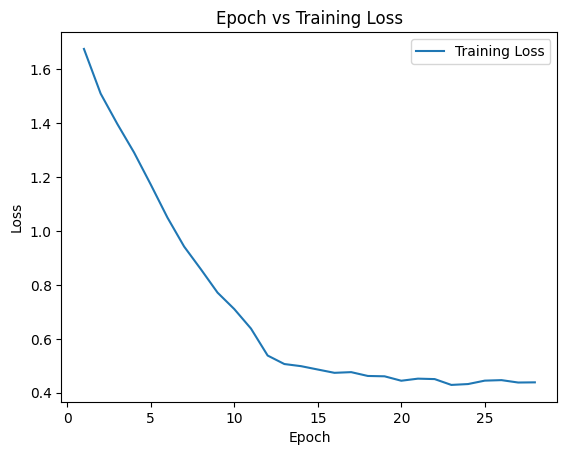

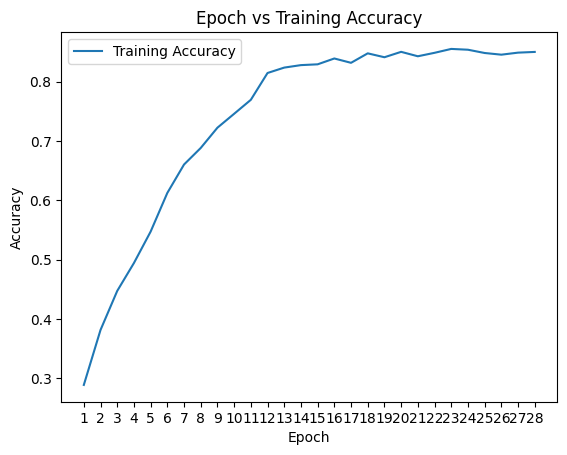

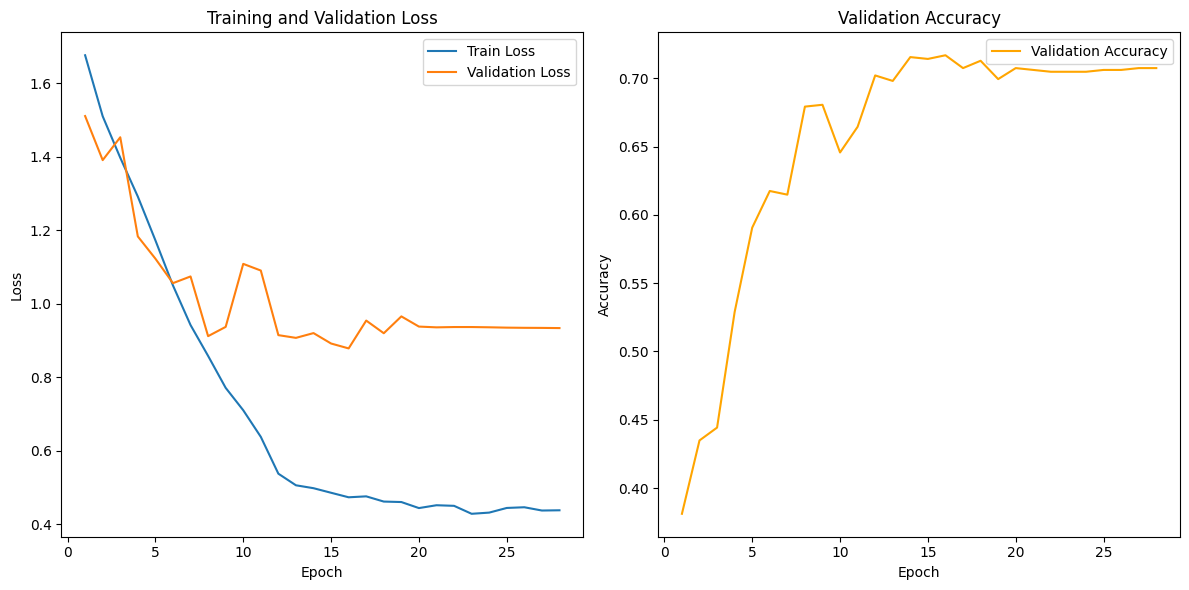

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Plot Epoch vs Training Loss
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(1, len(train_accuracies) + 1)  # Epochs from 1 to the number of epochs
plt.plot(acc_X, train_accuracies, "-", label="Training Accuracy")
plt.xticks(acc_X)  # Ensures x-axis shows every epoch number
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()


In [10]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

# Assuming test_loader is already defined as a DataLoader for your test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels": [], "predictions": []}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        # Assuming the input values are in the format of input_values and attention_mask
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        
        # Get predictions (assuming classification with argmax)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate correct predictions and total count
        correct += (preds == labels).sum().item()
        count += labels.size(0)
        
        # Calculate accuracy
        accuracy = correct / count
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        # Store the labels and predictions for classification report
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += preds.cpu().numpy().tolist()
        
    pbar.close()

    time.sleep(0.3)
    print(f"The final accuracy on the test dataset: {accuracy * 100:.4f}%")

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(record["labels"], record["predictions"], digits=4))


100%|██████████| 745/745 [00:15<00:00, 47.93it/s, loss=0.235, accuracy=0.718]


The final accuracy on the test dataset: 71.8121%

Classification Report:
              precision    recall  f1-score   support

           0     0.7515    0.9137    0.8247       139
           1     0.6692    0.6953    0.6820       128
           2     0.7010    0.5620    0.6239       121
           3     0.7589    0.6800    0.7173       125
           4     0.7563    0.7965    0.7759       113
           5     0.6609    0.6387    0.6496       119

    accuracy                         0.7181       745
   macro avg     0.7163    0.7143    0.7122       745
weighted avg     0.7167    0.7181    0.7142       745



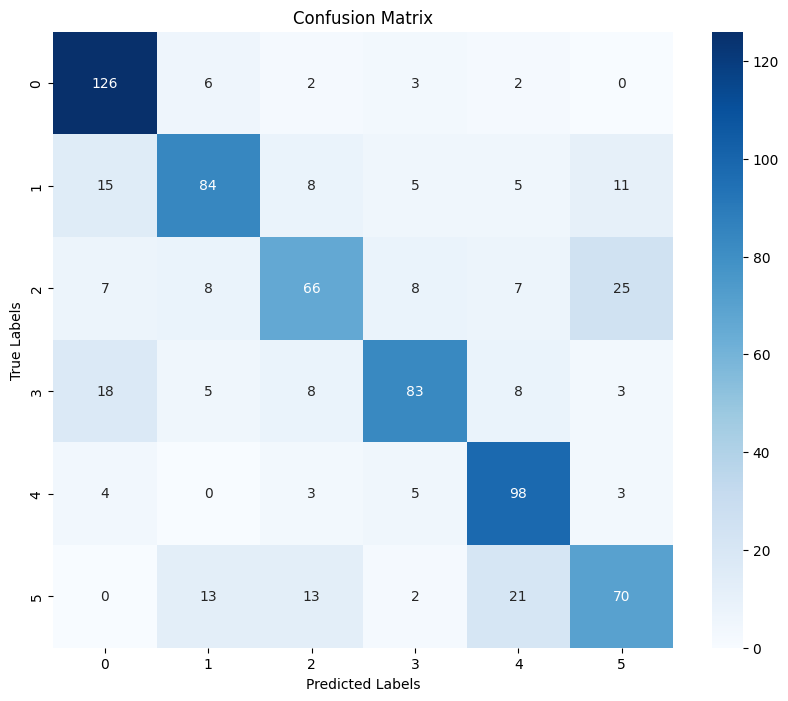

In [11]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()